In [85]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import torch
from networks.mlp_models import MLP3D
from data.neural_field_datasets_shapenet import AllWeights3D, ModelTransform3D, ShapeNetDataset, FlattenTransform3D, get_neuron_mean_n_std


shapeNetData = ShapeNetDataset("./datasets/plane_mlp_weights", transform=AllWeights3D())
means, stds = get_neuron_mean_n_std(shapeNetData)

In [87]:
torch.linalg.norm(shapeNetData[0][0], dim = 0).sort().values

tensor([ 1.3579,  1.6387,  1.7720,  1.9235,  2.2995,  2.4200,  2.6471,  2.7980,
         2.9732,  3.1400,  3.1435,  3.5269,  3.5661,  3.9233,  3.9532,  4.0908,
         4.5224,  4.8246,  5.1585,  5.7145,  5.9107,  6.5662,  6.7335,  6.7889,
         7.2702,  7.2993,  7.9146,  8.1124,  8.7261,  8.7788,  8.8282,  8.9303,
         9.0921,  9.2504,  9.2690,  9.4369,  9.8660,  9.9397,  9.9996, 10.0034,
        10.0957, 10.4005, 10.5390, 10.5687, 10.8225, 11.1356, 11.1371, 11.4603,
        11.4710, 11.5936, 11.6360, 11.8400, 11.8958, 11.9314, 11.9806, 11.9846,
        12.2048, 12.4704, 12.4839, 12.5296, 12.7327, 12.7754, 12.9201, 13.0979,
        13.1134, 13.1525, 13.4812, 13.6347, 13.7315, 13.7676, 13.9203, 13.9764,
        14.0136, 14.1815, 14.2548, 14.2815, 14.4758, 14.6640, 14.6825, 14.7554,
        14.8250, 14.9771, 15.0814, 15.3457, 15.5439, 15.5474, 15.5881, 15.6341,
        15.7206, 15.8377, 15.8552, 15.8895, 16.0252, 16.1471, 16.4492, 16.4846,
        16.8663, 16.8829, 16.8914, 17.25

In [88]:
torch.flip(shapeNetData[0][0].abs().sort().values)

TypeError: flip() missing 1 required positional arguments: "dims"

Shape of data is  torch.Size([287, 128])
Outlier neurons are  [[1, 10, 16, 22, 149], [1, 4, 10, 16, 22], [1, 10, 16, 22, 149], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 10, 16, 127, 139], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 10, 16, 22, 149], [1, 10, 16, 22, 70], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [55, 103, 117, 132, 149], [1, 4, 10, 16, 22], [1, 10, 16, 22, 53], [1, 10, 16, 22, 75], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22]]


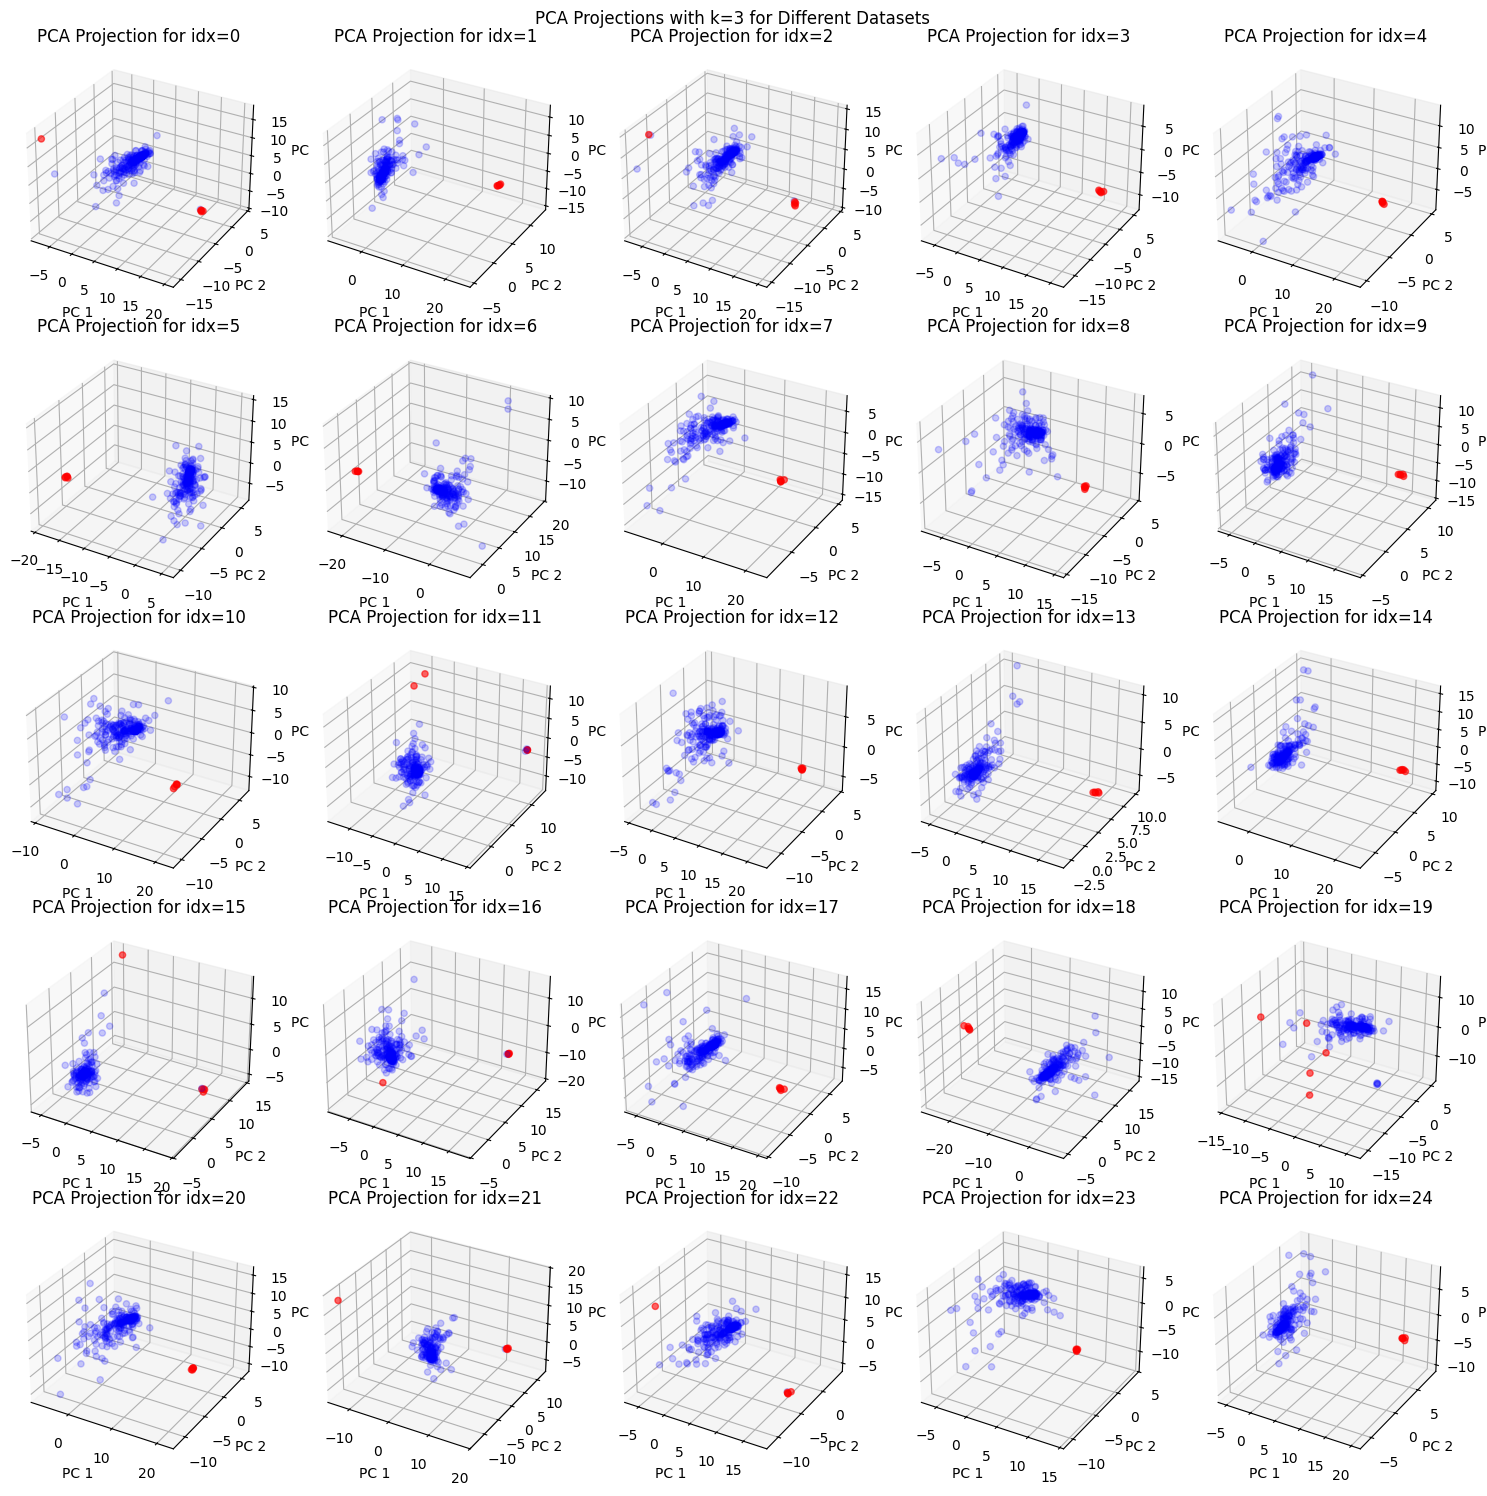

In [96]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot weights of different datasamples

# List of indices for different datasets
idxs = range(25)
#idxs = range(25, 50)

# Define the maximum norm
max_norm_count = 5

# Create a figure with 9 subplots
fig = plt.figure(figsize=(15, 15))

# Array to store indices of high norm points for each dataset
high_norm_indices = []

# Loop over each index and generate the PCA plot
for i, idx in enumerate(idxs):
    # Reshape the data
    data = shapeNetData[idx][0]

    # Center the data
    mean = torch.mean(data, dim=0)
    data_centered = data - mean

    # Compute the covariance matrix
    cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

    # Sort eigenvectors by decreasing eigenvalues
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select top 3 eigenvectors
    k = 3
    principal_components = eigenvectors[:, :k]

    # Project the data onto the top 3 principal components
    data_projected = torch.mm(data_centered, principal_components)

    # Compute norms
    norms = torch.linalg.norm(data_projected, dim=1)

    # Identify points with norm greater than max_norm
    high_norm_points = norms >= norms.sort().values[-max_norm_count]

    # Save indices of high norm points
    high_norm_indices.append(torch.nonzero(high_norm_points).squeeze().tolist())

    # Add subplot for the current index
    ax = fig.add_subplot(5, 5, i + 1, projection='3d')
    
    # Plot points with norm <= max_norm in blue
    ax.scatter(data_projected[~high_norm_points, 0], data_projected[~high_norm_points, 1], data_projected[~high_norm_points, 2], c='blue', alpha=0.2)
    
    # Plot points with norm > max_norm in red
    ax.scatter(data_projected[high_norm_points, 0], data_projected[high_norm_points, 1], data_projected[high_norm_points, 2], c='red', alpha=0.6)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(f'PCA Projection for idx={idx}')
    
print("Shape of data is ", data.shape)

print("Outlier neurons are ", high_norm_indices)

plt.suptitle('PCA Projections with k=3 for Different Datasets')
plt.tight_layout()
plt.show()




In [97]:
all_weights = torch.stack([sample[0] for sample in shapeNetData])
all_weights.shape

torch.Size([4045, 287, 128])

Shape of data is  torch.Size([4045, 128])


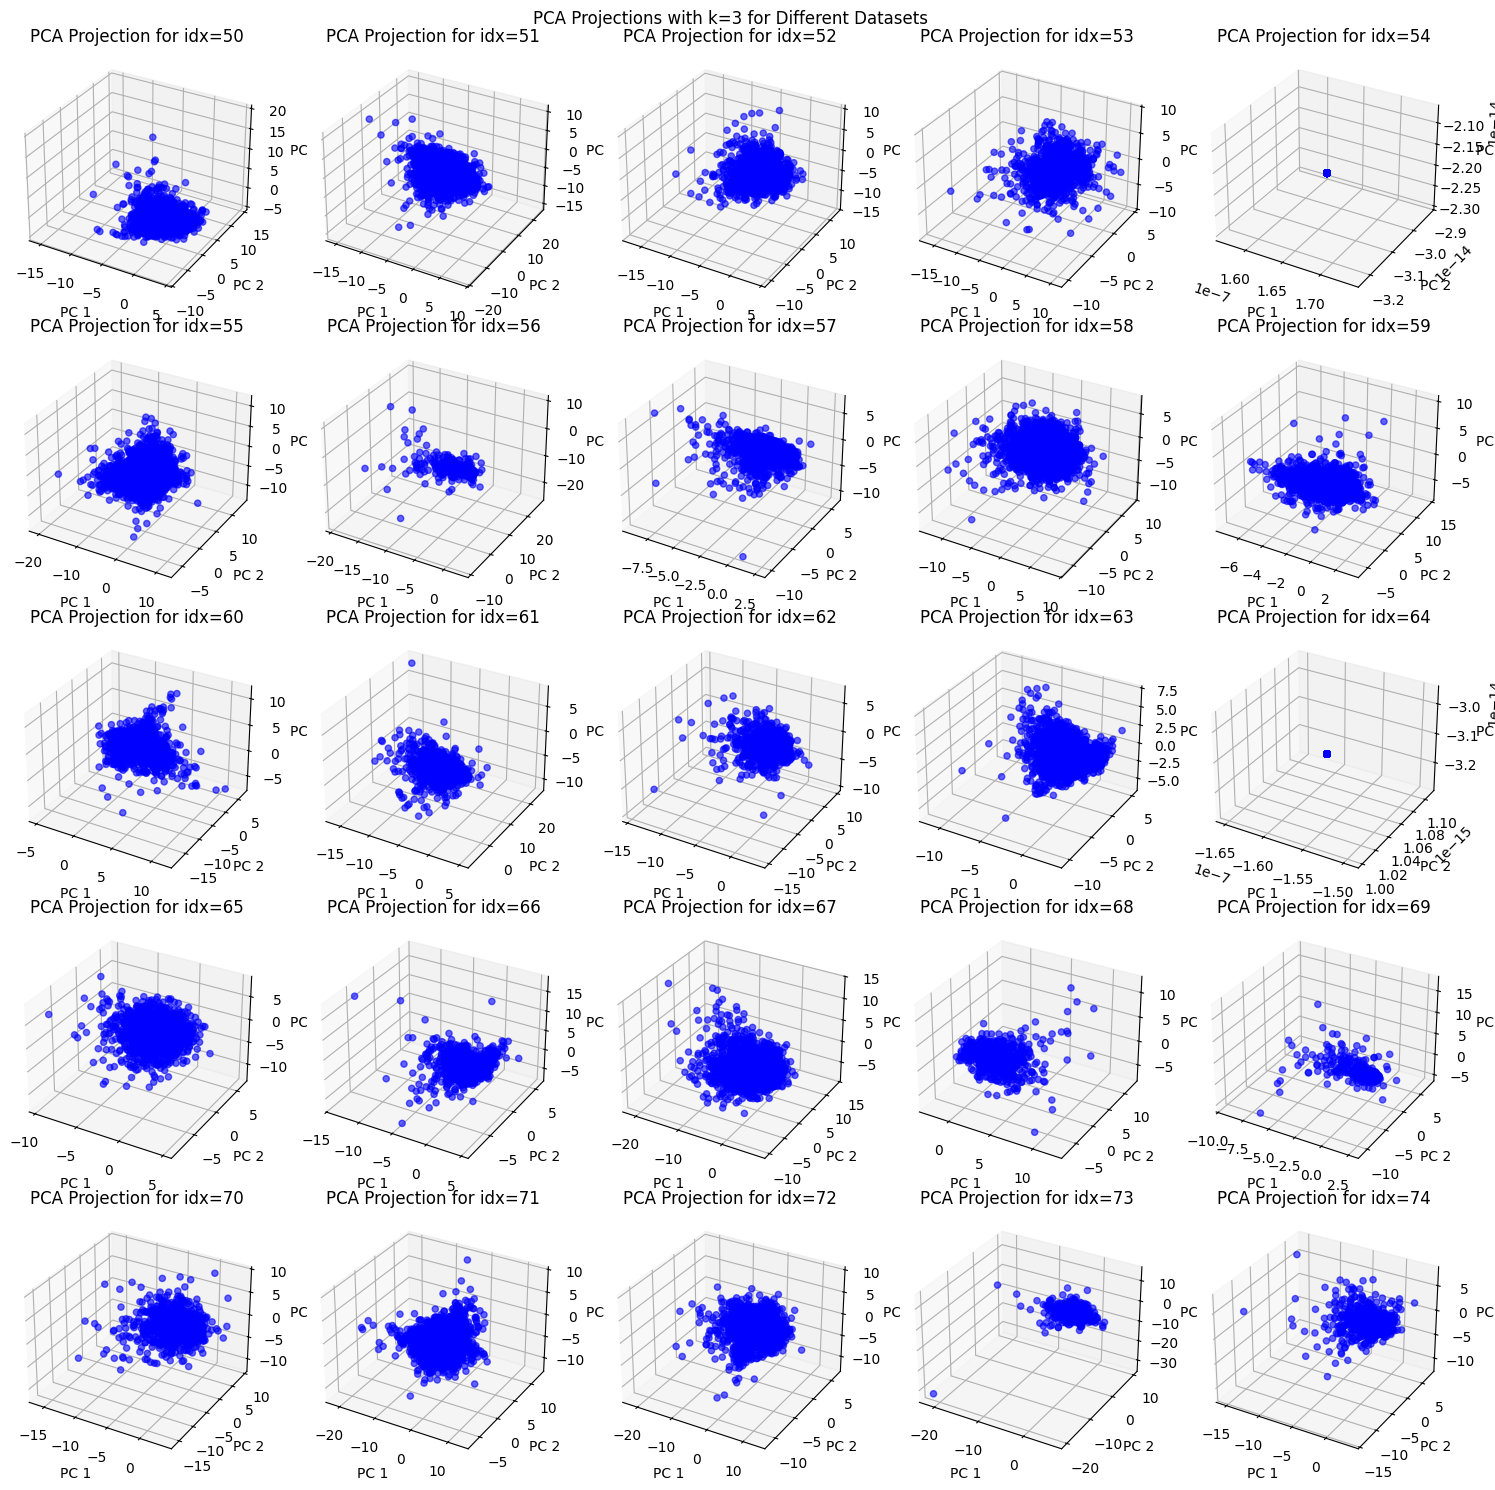

In [98]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# List of indices for different datasets
idxs = range(50, 75)

# Plot weights of different neurons

# Define the maximum norm
max_norm_count = 5

# Create a figure with 9 subplots
fig = plt.figure(figsize=(15, 15))

# Array to store indices of high norm points for each dataset
high_norm_indices = []

# Loop over each index and generate the PCA plot
for i, idx in enumerate(idxs):
    # Reshape the data
    data = all_weights[:, idx, :].view(-1, 128)

    # Center the data
    mean = torch.mean(data, dim=0)
    data_centered = data - mean

    # Compute the covariance matrix
    cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

    # Sort eigenvectors by decreasing eigenvalues
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select top 3 eigenvectors
    k = 3
    principal_components = eigenvectors[:, :k]

    # Project the data onto the top 3 principal components
    data_projected = torch.mm(data_centered, principal_components)

    # Compute norms
    norms = torch.linalg.norm(data_projected, dim=1)

    # Add subplot for the current index
    ax = fig.add_subplot(5, 5, i + 1, projection='3d')
    
    # Plot points with norm <= max_norm in blue    
    # Plot points with norm > max_norm in red
    ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2], c='blue', alpha=0.6)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(f'PCA Projection for idx={idx}')
    
    
print("Shape of data is [idx nef, weight tensor]", data.shape)

plt.suptitle('PCA Projections with k=3 for Different Datasets')
plt.tight_layout()
plt.show()





In [68]:
all_weights.shape

torch.Size([4045, 287, 128])

tensor([  0,   0,   0,  ..., 286, 286, 286])


/var/folders/t7/38s2h7694tsbtc8hjlcdxvwm0000gn/T/ipykernel_42181/891908505.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


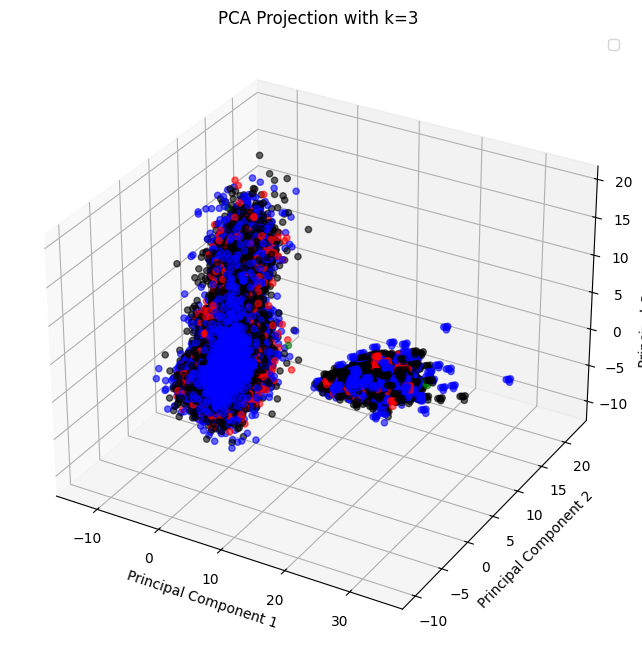

In [83]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)
print(labels)

# Reshape the data
data = all_weights.view(-1, 128)

# Center the data
mean = torch.mean(data, dim=0)
data_centered = data - mean

# Compute the covariance matrix
cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

# Sort eigenvectors by decreasing eigenvalues
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, sorted_indices]

# Select top 3 eigenvectors
k = 3
principal_components = eigenvectors[:, :k]

# Project the data onto the top 3 principal components
data_projected = torch.mm(data_centered, principal_components)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


# weights layer 0
for class_idx in range(27):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="red")

# weights layer 1
for class_idx in range(27, 27 + 128):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="blue")
    
# weights layer 2
for class_idx in range(27 + 128, 27 + 2*128):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="black")
    
# weights layer 3
for class_idx in range(27 + 2*128, 27 + 2*128 + 1):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="green")



ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('PCA Projection with k=3')
plt.legend()
plt.show()



tensor([  0,   0,   0,  ..., 286, 286, 286])


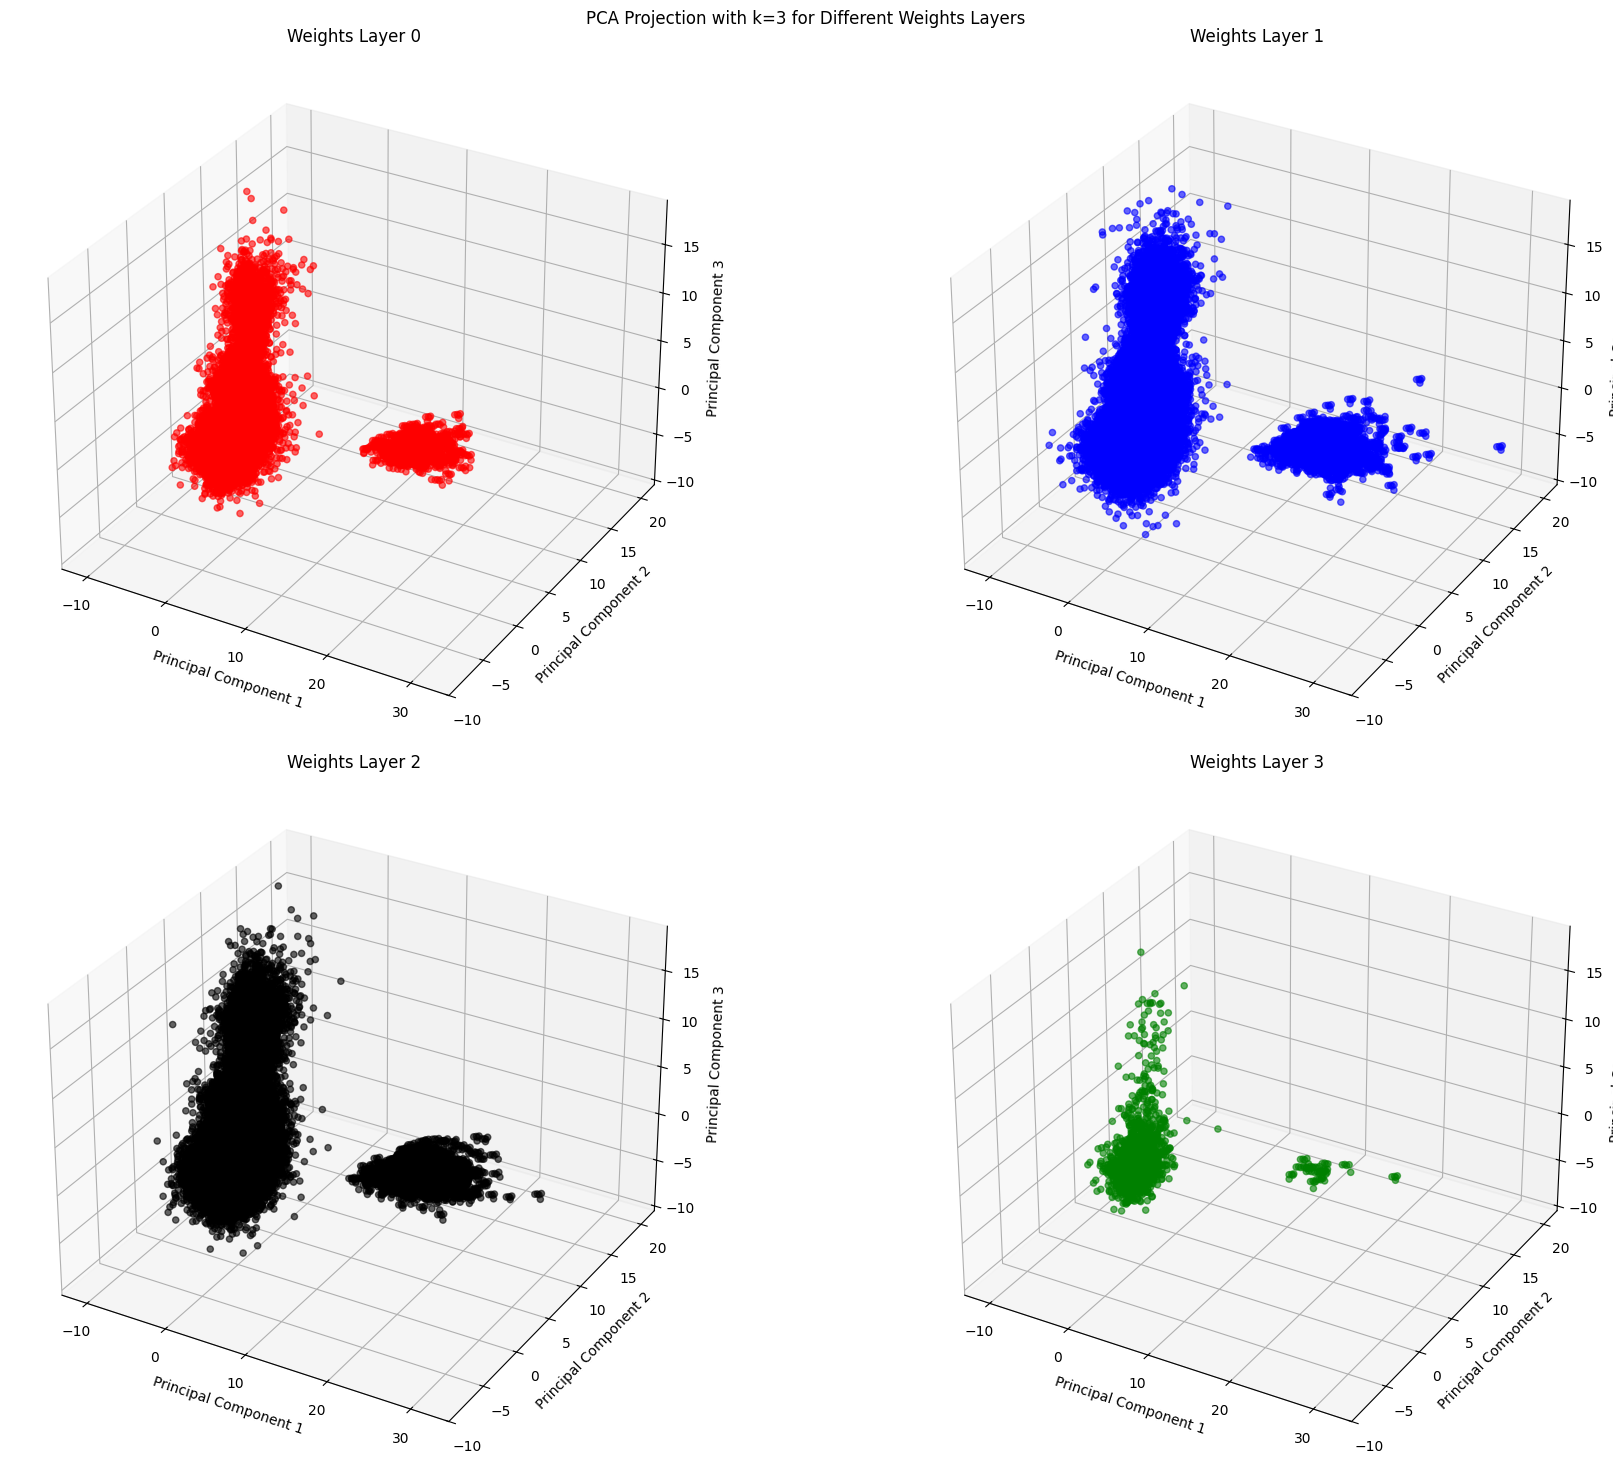

In [84]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)
print(labels)

# Reshape the data
data = all_weights.view(-1, 128)

# Center the data
mean = torch.mean(data, dim=0)
data_centered = data - mean

# Compute the covariance matrix
cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

# Sort eigenvectors by decreasing eigenvalues
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, sorted_indices]

# Select top 3 eigenvectors
k = 3
principal_components = eigenvectors[:, :k]

# Project the data onto the top 3 principal components
data_projected = torch.mm(data_centered, principal_components)

# Get axis limits for consistent comparison
min_vals = data_projected.min(dim=0).values
max_vals = data_projected.max(dim=0).values

# Visualization for each layer
fig = plt.figure(figsize=(20, 15))

# Weights layer 0
ax1 = fig.add_subplot(221, projection='3d')
for class_idx in range(27):
    class_data = data_projected[labels == class_idx]
    ax1.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="red")
ax1.set_xlim(min_vals[0].item(), max_vals[0].item())
ax1.set_ylim(min_vals[1].item(), max_vals[1].item())
ax1.set_zlim(min_vals[2].item(), max_vals[2].item())
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
ax1.set_title('Weights Layer 0')

# Weights layer 1
ax2 = fig.add_subplot(222, projection='3d')
for class_idx in range(27, 27 + 128):
    class_data = data_projected[labels == class_idx]
    ax2.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="blue")
ax2.set_xlim(min_vals[0].item(), max_vals[0].item())
ax2.set_ylim(min_vals[1].item(), max_vals[1].item())
ax2.set_zlim(min_vals[2].item(), max_vals[2].item())
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('Weights Layer 1')

# Weights layer 2
ax3 = fig.add_subplot(223, projection='3d')
for class_idx in range(27 + 128, 27 + 2 * 128):
    class_data = data_projected[labels == class_idx]
    ax3.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="black")
ax3.set_xlim(min_vals[0].item(), max_vals[0].item())
ax3.set_ylim(min_vals[1].item(), max_vals[1].item())
ax3.set_zlim(min_vals[2].item(), max_vals[2].item())
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
ax3.set_zlabel('Principal Component 3')
ax3.set_title('Weights Layer 2')

# Weights layer 3
ax4 = fig.add_subplot(224, projection='3d')
for class_idx in range(27 + 2 * 128, 27 + 2 * 128 + 1):
    class_data = data_projected[labels == class_idx]
    ax4.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="green")
ax4.set_xlim(min_vals[0].item(), max_vals[0].item())
ax4.set_ylim(min_vals[1].item(), max_vals[1].item())
ax4.set_zlim(min_vals[2].item(), max_vals[2].item())
ax4.set_xlabel('Principal Component 1')
ax4.set_ylabel('Principal Component 2')
ax4.set_zlabel('Principal Component 3')
ax4.set_title('Weights Layer 3')

plt.suptitle('PCA Projection with k=3 for Different Weights Layers')
plt.tight_layout()
plt.show()


In [101]:
error.shape

torch.Size([4045, 287, 128])

In [118]:
from tqdm import tqdm
# example use
weight_vector = all_weights[0]
mean = 0

for weight_vector in tqdm(shapeNetData):

    error = all_weights - all_weights[0]

    # the absolute value of each error weight vector
    error = torch.linalg.norm(error, dim = 2)

    # the mean accross all neurons and nef
    mean_error = error.mean()
    mean += mean_error
    
mean = mean / len(shapeNetData)
print(mean)

torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045, 287])
torch.Size([4045, 287, 128])
torch.Size([4045,

KeyboardInterrupt: 

torch.Size([1160915, 128])

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate class labels
labels = torch.arange(27).repeat_interleave(4045)

# Reshape the data
data = all_weights[8] #all_weights.view(-1, 128)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the autoencoder
num_epochs = 100
batch_size = 16
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for batch in data_loader:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
# cmap = plt.get_cmap("tab20", 27)
# colors = cmap(labels)

# # Plot each class with its respective color
# for class_idx in range(27):
#     class_data = latent_space[labels == class_idx]
#     ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])

class_data = latent_space#[labels == class_idx]
ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])



ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


Epoch [1/100], Loss: 0.0103
Epoch [2/100], Loss: 0.0108
Epoch [3/100], Loss: 0.0094
Epoch [4/100], Loss: 0.0099
Epoch [5/100], Loss: 0.0092
Epoch [6/100], Loss: 0.0075
Epoch [7/100], Loss: 0.0080
Epoch [8/100], Loss: 0.0091
Epoch [9/100], Loss: 0.0076
Epoch [10/100], Loss: 0.0092
Epoch [11/100], Loss: 0.0103
Epoch [12/100], Loss: 0.0082
Epoch [13/100], Loss: 0.0083
Epoch [14/100], Loss: 0.0078
Epoch [15/100], Loss: 0.0087
Epoch [16/100], Loss: 0.0078
Epoch [17/100], Loss: 0.0090
Epoch [18/100], Loss: 0.0083
Epoch [19/100], Loss: 0.0090
Epoch [20/100], Loss: 0.0070
Epoch [21/100], Loss: 0.0072
Epoch [22/100], Loss: 0.0097
Epoch [23/100], Loss: 0.0084
Epoch [24/100], Loss: 0.0089
Epoch [25/100], Loss: 0.0102
Epoch [26/100], Loss: 0.0079
Epoch [27/100], Loss: 0.0076
Epoch [28/100], Loss: 0.0080
Epoch [29/100], Loss: 0.0071
Epoch [30/100], Loss: 0.0082
Epoch [31/100], Loss: 0.0087
Epoch [32/100], Loss: 0.0092
Epoch [33/100], Loss: 0.0076
Epoch [34/100], Loss: 0.0078
Epoch [35/100], Loss: 0

KeyboardInterrupt: 

In [35]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Generate class labels
labels = torch.arange(27).repeat_interleave(4045)

# Reshape the data
data = all_weights.view(-1, 128)

# Convert data to numpy array for t-SNE
data_np = data.numpy()

# Perform 3D t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
data_tsne = tsne.fit_transform(data_np)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# Plot each class with its respective color
for class_idx in range(27):
    class_data = data_tsne[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.title('3D t-SNE Projection')
plt.legend()
plt.show()


/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 